In [275]:
# This code will perform perform SVD on the A matrix and extract the relevant coherent structures

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

In [277]:
# Read Input
def read_variables_to_globals(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f.readlines()]

    for i in range(0, len(lines), 2):
        var_name = lines[i]
        raw_value = lines[i+1]

        try:
            value = int(raw_value)
        except ValueError:
            try:
                value = float(raw_value)
            except ValueError:
                value = raw_value

        globals()[var_name] = value  # Define variable in global scope

In [278]:
# Perform SVD on a normal computer
# Compute Correlation matrix 
#   -> Compute eigenvectors (temporal modes) and square root of eigenvalues of correlation matrix (singular values)
#       -> Compute the leading k modes of U based on the desired input
def POD_regular(ProjectName, NumSS, NumModes):
    # NumSS == Number of Snapshots -> Determines how big the square matrix is 

    corr = np.zeros((NumSS, NumSS))  # Initialize correlation matrix
    ModeSize = 0 # Intialize the size of each mode

    # Perform every dot product combo on the column snapshots in order to build the correlation matrix
    for i in range(NumSS):
        for j in range(i, NumSS):  # j starts at i
            snap_id_a = i + 1
            snap_id_b = j + 1

            snap_filename_a = ProjectName + "_SnapShot_"  + str(snap_id_a) + ".txt"
            snap_filename_b = ProjectName + "_SnapShot_"  + str(snap_id_b) + ".txt"

            snap_a = np.loadtxt(snap_filename_a)
            snap_b = np.loadtxt(snap_filename_b)

            if i == 0 and j == 0:
                ModeSize = len(snap_a)

            corr[i, j] = np.dot(snap_a, snap_b) 
            corr[j, i] = corr[i, j]       # fill symmetric entry
    
    print("Number of Modes we want to compute:")
    print(NumModes)

    print("Size of each mode:")
    print(ModeSize)

    print("Correlation Matrix By hand:")
    print(corr)

    eig_corr, tempModes = eigsh(corr)
    
    tempModes = tempModes[:, ::-1]  # Flip columns

    Vt = np.transpose(tempModes)
    S = np.sqrt(eig_corr)
    S = S[::-1]

    U = np.zeros((ModeSize, NumModes))

    for k in range(NumModes): # Loop to calculate each mode: A*V*sigma^-1
        mode_init = np.zeros(ModeSize)
        # Loop over all snapshots to perform A*V
        for i in range(NumSS):
            snapshot_id = i + 1
            snap_filename = ProjectName + "_SnapShot_"  + str(snapshot_id) + ".txt"
            snapshot = np.loadtxt(snap_filename)
            
            mode_init = mode_init + snapshot*Vt[k,i]*S[k]**(-1)

        U[:, k] = mode_init

    print("From manual:")
    print("U =", U)
    print("S =", S)
    print("V^T =", Vt)

    # # Validate Correlation Matrix through direct computation
    # snapshot_mat_full =  np.loadtxt("ToyData_Snapshot_Mat.txt")
    # corr_val = np.dot(np.transpose(snapshot_mat_full), snapshot_mat_full)

    # print("Correlation Matrix for Validation:")
    # print(corr_val)

    return U, S, Vt

In [279]:
# This Block is for validating the above block to make sure that what it is outputting makes sense
def POD_regular_validate(ProjectName):
    SnapShotMat_filename = ProjectName + "_SnapShot_Mat.txt"
    SnapShot_Mat = np.loadtxt(SnapShotMat_filename)
    U, S, Vt = np.linalg.svd(SnapShot_Mat, full_matrices=False)
    print("From validation:")
    print("U =", U)
    print("S =", S)
    print("V^T =", Vt)
    return U, S, Vt

In [ ]:
# TODO: Spectral POD (sPOD) Calculation
# 

In [280]:
# Percentage of Energy Captured from k rank approximation
def energy_captured(S, NumModes):
    energy_ratio = np.sum(S[:NumModes]**2) / np.sum(S**2)
    return energy_ratio

In [281]:
# Plot Log of normalized singular values
def plot_singular(S, titlename):
    # Create the plot

    x = np.arange(1, len(S) + 1)
    plt.plot(x, np.log10(S / np.max(S)))

    # Add labels and title
    plt.xlabel('Singular Values')
    plt.ylabel('Log of Normalized Singular Values')
    plt.title(titlename)

    # Show the plot
    plt.show()

In [282]:
# Plot the temporal modes
def plot_temporal_modes(Vt, NumModes):
    """
    Plots the first NumModes temporal modes from Vt (rows of Vt).
    
    Parameters:
    - Vt: 2D numpy array (shape: NumModes x NumSnapshots)
    - NumModes: number of leading modes to plot
    """
    fig, axs = plt.subplots(NumModes, 1, figsize=(8, 2.5 * NumModes), sharex=True)

    if NumModes == 1:
        axs = [axs]  # wrap single axis in list for consistency

    for i in range(NumModes):
        axs[i].plot(Vt[i], linewidth=2)
        axs[i].set_title(f"Temporal Mode {i+1}", fontsize=12)
        axs[i].set_ylabel("Amplitude")
        axs[i].grid(True)

    axs[-1].set_xlabel("Snapshot time index (temporary)")
    plt.tight_layout()
    plt.show()

In [283]:
def main(ProjectName, NumSS, NumModes):
    # SVD for computation of 
    U, S, Vt = POD_regular(ProjectName, NumSS, NumModes)
    # SVD on complete matrix for validation
    U_val, S_val, Vt_val = POD_regular_validate(ProjectName)

    # Spectral POD Computation

    return U, S, Vt, U_val, S_val, Vt_val

Number of Modes we want to compute:
2
Size of each mode:
10
Correlation Matrix By hand:
[[501. 493. 393. 319. 377.]
 [493. 560. 431. 338. 334.]
 [393. 431. 500. 305. 365.]
 [319. 338. 305. 323. 309.]
 [377. 334. 365. 309. 435.]]
From manual:
U = [[-0.32261176  0.10665428]
 [-0.38752193  0.08684118]
 [-0.29491243  0.44701689]
 [-0.28320617 -0.21769616]
 [-0.3353448   0.17638409]
 [-0.30070683 -0.39952631]
 [-0.33181823 -0.49676266]
 [-0.31918548  0.49344361]
 [-0.29505606 -0.22982104]
 [-0.2768534  -0.00759595]]
S = [44.18105164 13.08418101 10.67028131  8.38289546  3.42214017]
V^T = [[-0.48261011 -0.50118597 -0.4600497  -0.36336126 -0.41499755]
 [-0.26972765 -0.61282255  0.14762291  0.22648594  0.69181436]
 [ 0.37087019  0.01948682 -0.85177599  0.26596902  0.25654183]
 [-0.44749461  0.1298917  -0.03179329  0.82343846 -0.32220338]
 [ 0.59710832 -0.59666536  0.20007147  0.26054233 -0.42372302]]
From validation:
U = [[-0.32261176  0.10665428 -0.12530136  0.10109236 -0.18238453]
 [-0.387521

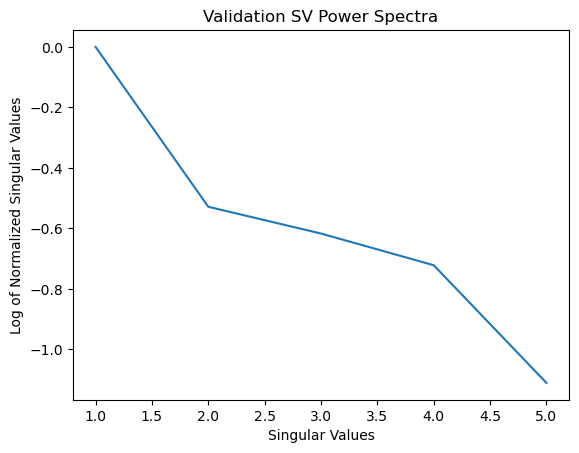

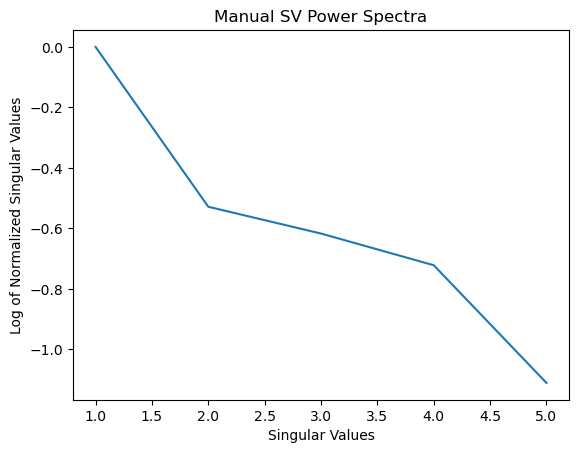

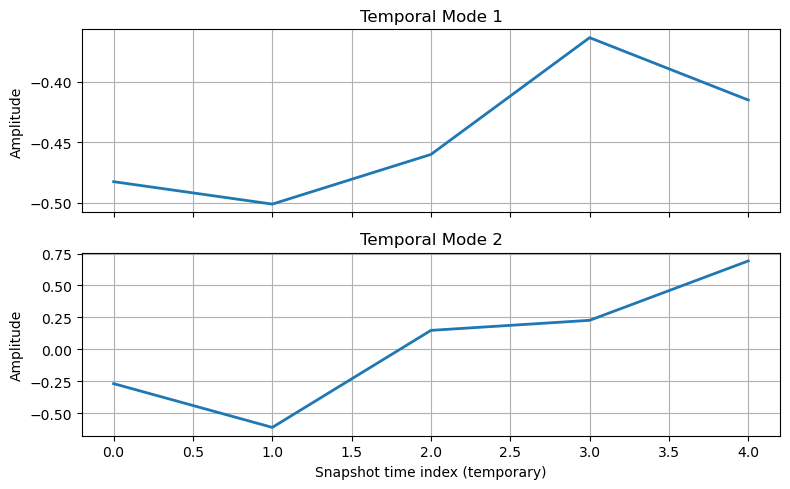

Energy Captured:
0.9155502876578059


In [ ]:
if __name__ == "__main__":
    # Read Variables
    inputs = read_variables_to_globals("input_POD.txt")
    
    U, S, Vt, U_val, S_val, Vt_val = main(ProjectName, NumSS, NumModes)

    # Plot Singular Value Spectra
    plot_singular(S_val, 'Validation SV Power Spectra')
    plot_singular(S, 'Manual SV Power Spectra')

    # Plot Temporal modes
    plot_temporal_modes(Vt, NumModes)

    # Output Percentage of Energy Captured from k rank approximation
    e_cap = energy_captured(S, NumModes)
    print("Energy Captured:")
    print(e_cap)

    # TODO: Print the Modes to text files
